### Spectrum Equation
$$
R(O^-, H)_{(\lambda)} = \frac{bb_{(\lambda)}}{2 K_{(\lambda)}} + \left( R_{b(\lambda)} - \frac{bb_{(\lambda)}}{2 K_{(\lambda)}}\right) e^{-2K_{(\lambda)} H}
$$

Where:
 - $R(O^-, H)$ is the reflectance below the water  (i.e. glint corrected)
 - $bb_{(\lambda)}$ is the backscatter coefficient
 - $K_{(\lambda)}$ is the attenuation coefficient
 - $R_{b(\lambda)}$ is the bottom reflectance

### Glint Correction
 - Subtract the infrared intensity band from the entire spectrum

### Task: How to accurately retrieve the bottom reflectance from the spectrum?


In [1]:
%load_ext autoreload
%autoreload 2

In [536]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize
from sklearn.metrics import r2_score
# from scipy.optimize import minimize
from scipy import stats

import seaborn as sns

from tqdm.auto import tqdm

from reflectance.spectrum import sub_surface_reflectance, AOP_model

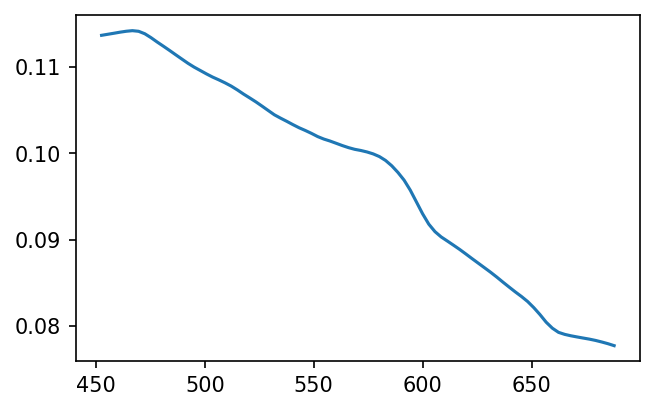

In [539]:
plt.plot(wv, AOP_model.loc[wv].bb_m + AOP_model.loc[wv].bb_c)

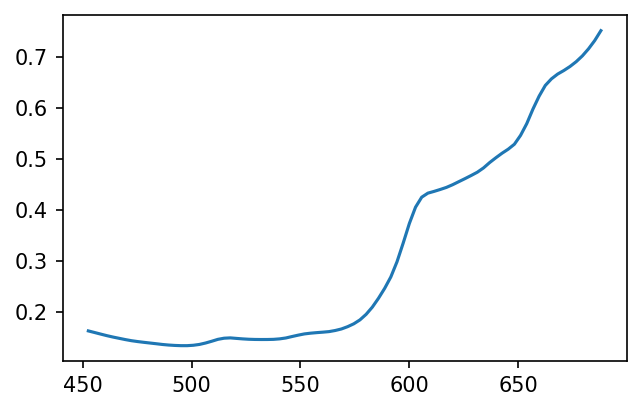

In [540]:
plt.plot(wv, AOP_model.loc[wv].Kd_m + AOP_model.loc[wv].Kd_c)

In [3]:
validation_data = pd.read_csv('data/CORAL_validation_data.csv')
spectra_raw = pd.read_csv('data/CORAL_validation_spectra.csv')
spectra_raw.columns = spectra_raw.columns.astype(float)

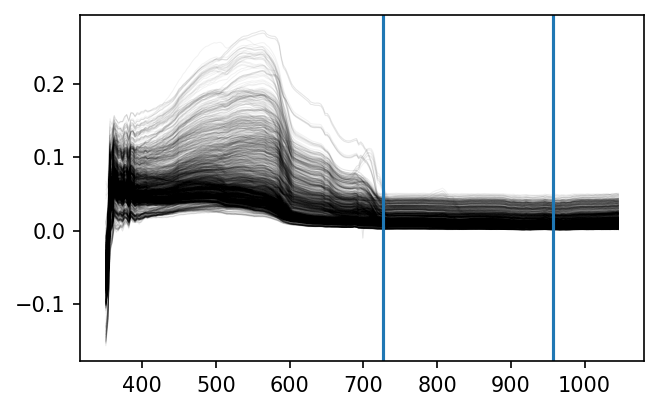

In [4]:
# example spectrum
i = 0
plt.plot(spectra_raw.columns, spectra_raw.values.T, color=(0,0,0,0.05), lw=0.5);
# NIR waveband
plt.axvline(727)
plt.axvline(957)

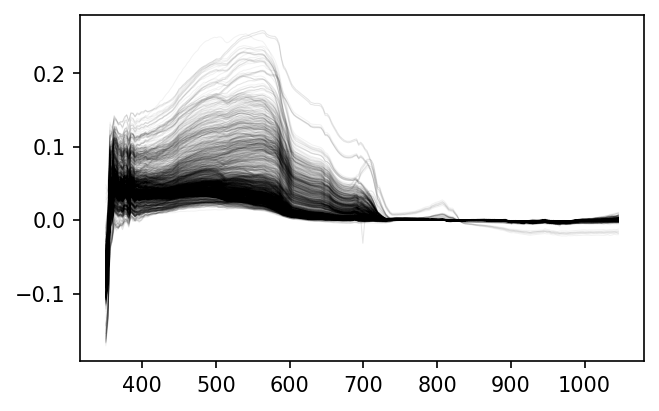

In [395]:
# sun glint correction - subtract values between 727 and 957 from rest of data
ind = (spectra_raw.columns > 727) & (spectra_raw.columns < 957)
spectra_corrected = spectra_raw.subtract(spectra_raw.loc[:, ind].mean(axis=1), axis=0)
# plot corrected spectra
plt.plot(spectra_corrected.columns, spectra_corrected.values.T, color=(0,0,0,0.05), lw=0.5);

In [7]:
# calculate sub-surface reflectance (from Lee et al. 1998)
spectra_corrected = spectra_corrected / (0.518 + 1.562 * spectra_corrected)

In [8]:
# clip spectra to AOP valid range (instrument calibration limitations)
ind = (spectra_corrected.columns > 450) & (spectra_corrected.columns < 690)
spectra = spectra_corrected.loc[:, ind]

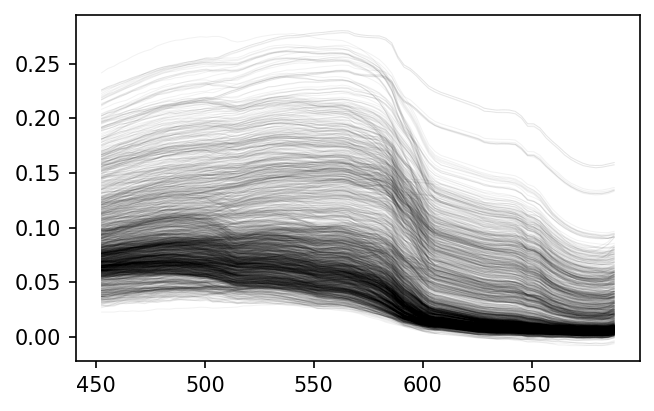

In [9]:
plt.plot(spectra.columns, spectra.values.T, color=(0,0,0,0.05), lw=0.5);

In [402]:
spectra.loc[i]

452.642775    0.159606
455.475056    0.161124
458.307394    0.162525
461.139788    0.163811
463.972238    0.165091
                ...   
676.566275    0.063057
679.402999    0.062114
682.239779    0.061799
685.076616    0.061956
687.913509    0.063214
Name: 0, Length: 84, dtype: float64

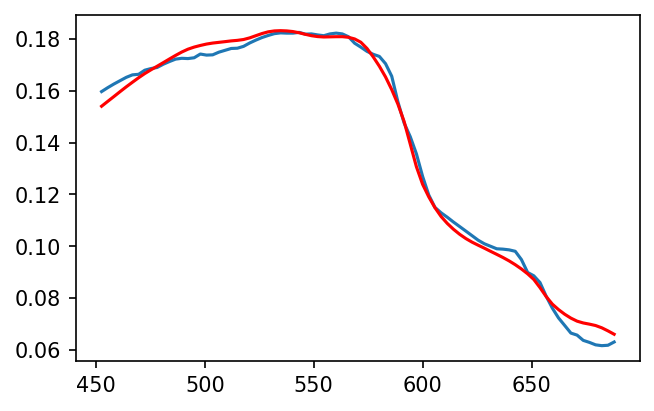

In [396]:
i = 0
plt.plot(spectra.columns, spectra.loc[i]);

AOD_sub = AOP_model.loc[spectra.columns]
AOD_args = (AOD_sub.bb_m.values, AOD_sub.bb_c.values, AOD_sub.Kd_m.values, AOD_sub.Kd_c.values)

# fitting curve with scalar(?) Rb
p, cov = curve_fit(lambda x, bb, Kd, Rb, H: sub_surface_reflectance(x, bb, Kd, Rb, H, *AOD_args),
                   spectra.columns, spectra.loc[i], p0=[0.1, 0.1, 0, 0],    # initialisation
                   bounds=([0, 0.01688, 0, -1], [0.41123, 3.17231, np.inf, np.inf]))    # value bounds (from AOP model)
plt.plot(spectra.columns, sub_surface_reflectance(spectra.columns, *p, *AOD_args), color='red')

## Average Component-based Rb model

In [15]:
f = 'reflectance/resources/spectral_library_clean_v3_PRISM_wavebands.csv'
df = pd.read_csv(f, skiprows=1).set_index('wavelength')
df.columns = df.columns.astype(float)
df = df.astype(float)

# clip to valid wv range
df = df.loc[:, spectra.columns]

In [263]:
cats = df.index.unique()  # get categories

end_members = {}
for cat in cats:
    ind = df.index == cat
    end_members[cat] = df.loc[ind].mean(axis=0)
end_member_array = np.array([spectrum.values for spectrum in end_members.values()])

def Rb_endmember(*X):
    return end_member_array.T.dot(X)

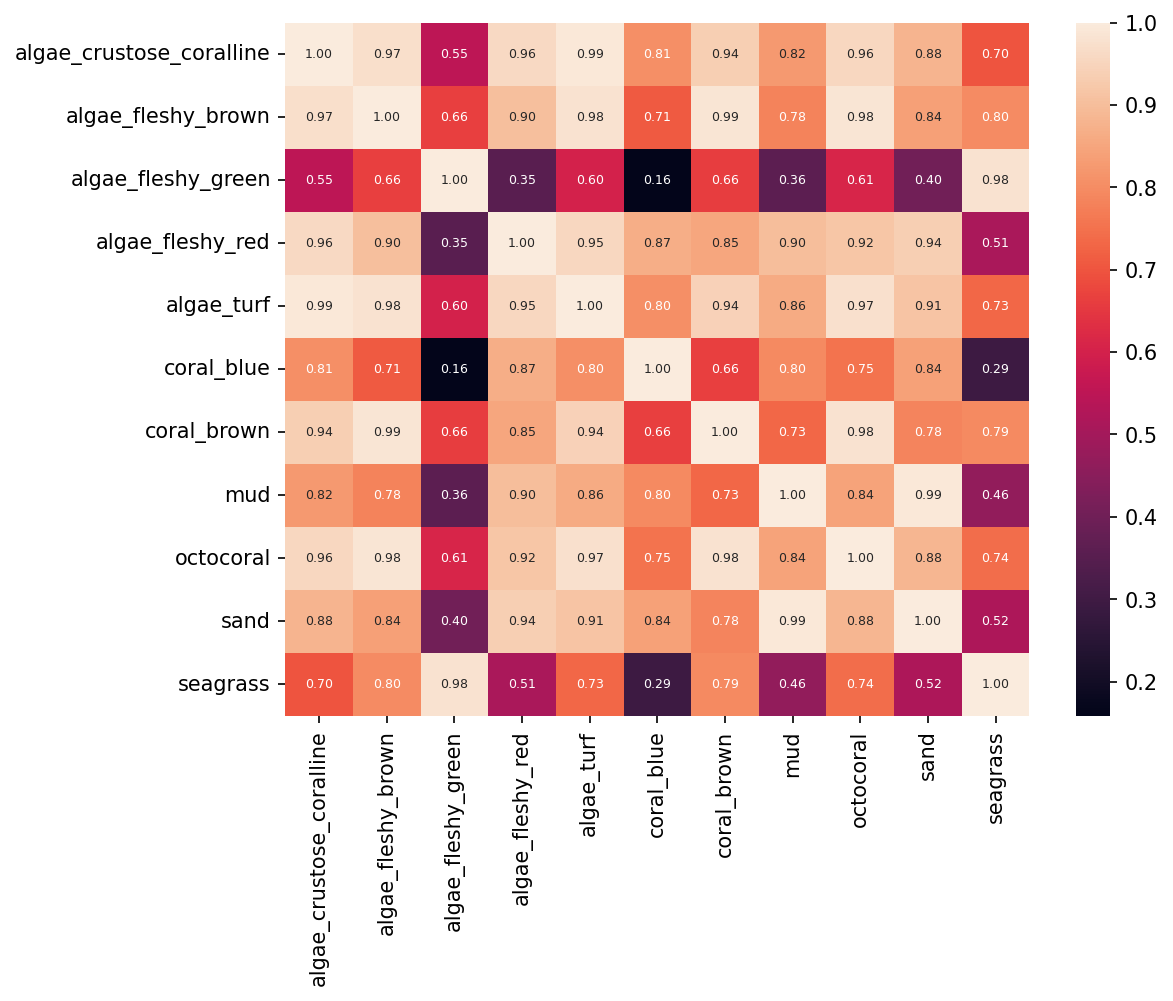

In [262]:
plt.figure(figsize=[8,6])
ax = sns.heatmap(np.corrcoef(end_member_array), annot=True, fmt='.2f', annot_kws={'fontsize':6})
ax.set_xticklabels(cats, rotation=90)
ax.set_yticklabels(cats, rotation=0);

In [306]:
def sub_surface_reflectance_Rb(wv, bb, K, H, Rb0, Rb1, Rb2, Rb3, Rb4, Rb5, Rb6, Rb7, Rb8, Rb9, Rb10, bb_m, bb_c, Kd_m, Kd_c):
    Rb = Rb_endmember(Rb0, Rb1, Rb2, Rb3, Rb4, Rb5, Rb6, Rb7, Rb8, Rb9, Rb10)
    return sub_surface_reflectance(wv, bb, K, H, Rb, bb_m, bb_c, Kd_m, Kd_c)

def objective_fn(x, obs, bb_m, bb_c, Kd_m, Kd_c):
    bb, K, H, Rb0, Rb1, Rb2, Rb3, Rb4, Rb5, Rb6, Rb7, Rb8, Rb9, Rb10 = x
    Rb = Rb_endmember(Rb0, Rb1, Rb2, Rb3, Rb4, Rb5, Rb6, Rb7, Rb8, Rb9, Rb10)
    pred = sub_surface_reflectance(1, bb, K, H, Rb, bb_m, bb_c, Kd_m, Kd_c)
    
    ssq = np.sum((obs - pred)**2)
    penalty = np.sum(np.array([Rb0, Rb1, Rb2, Rb3, Rb4, Rb5, Rb6, Rb7, Rb8, Rb9, Rb10])**2)
    penalty_scale = ssq / max(penalty.max(), 1)  # doesn't this just remove the Rb penalty?
    return ssq + penalty_scale * penalty

def _wrapper(i):
    fit = minimize(objective_fn,
               x0=[0.1, 0.1, 0] + [0] * 11,
               args=(spectra.loc[i], *AOD_args),
               bounds=[(0, 0.41123), (0.01688, 3.17231), (0, 50)] + [(0, np.inf)] * 11)
    return fit.x

In [110]:
import multiprocessing as mp

In [170]:
rerun = False

if rerun:
    with mp.Pool() as pool:
        result = list(tqdm(pool.imap(_wrapper, spectra.index), total=len(spectra.index)))
        
    fits = pd.DataFrame(result, index=spectra.index, columns=['bb', 'K', 'H'] + list(cats))
    fits.to_csv('tmp/fits_avg_endmembers.csv')
else:
    fits = pd.read_csv('tmp/fits_avg_endmembers.csv', index_col=0)
    

In [173]:
fits['r2'] = np.nan
for i, row in tqdm(fits.iterrows(), total=len(fits)):
    pred = sub_surface_reflectance_Rb(spectra.columns, *row.values[:-1], *AOD_args)
    fits.loc[i, 'r2'] = r2_score(spectra.loc[i], pred)

  0%|          | 0/1938 [00:00<?, ?it/s]

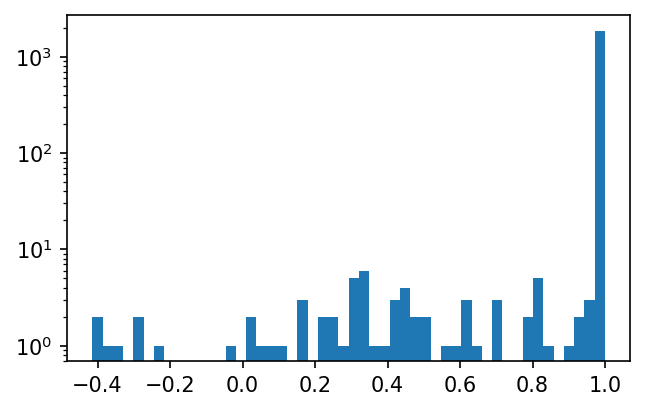

In [222]:
plt.hist(fits.r2, bins=50);
plt.yscale('log')

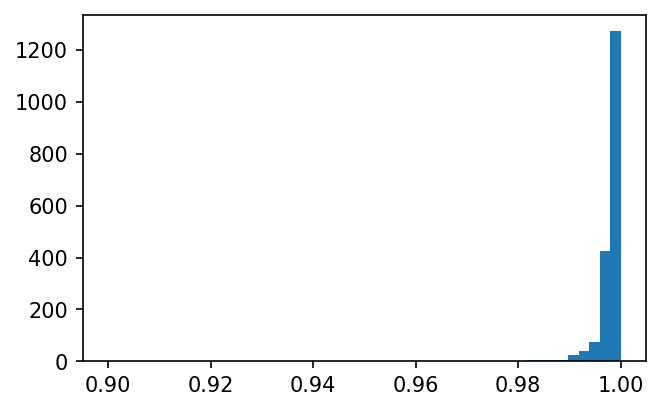

In [225]:
plt.hist(fits.r2, bins=np.linspace(0.9,1,50));

0.005313808422208743


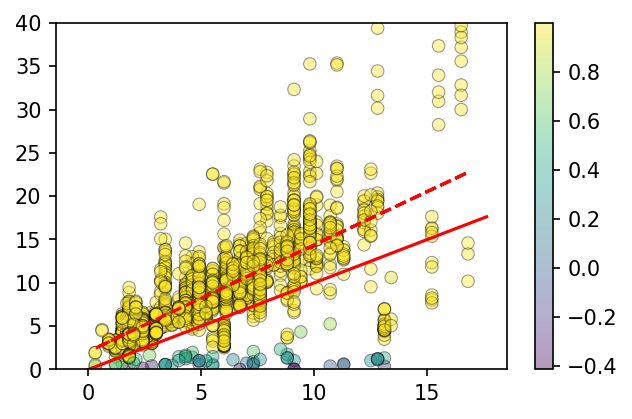

In [218]:
fig, ax = plt.subplots()
ma = ax.scatter(validation_data.Depth, fits.H, alpha=0.4, c=fits.r2, edgecolor='k', lw=0.5)
ax.plot(ax.get_xlim(),ax.get_xlim(), color='r')

p = np.polyfit(validation_data.Depth, fits.H, 1)
pred = np.polyval(p, validation_data.Depth)
r2 = r2_score(validation_data.Depth, pred)
print(r2)

ax.plot(validation_data.Depth, pred, color='r', ls='--')

ax.set_ylim(0,40)

fig.colorbar(ma)


In [206]:
endmember_contribution.shape

(11, 84)

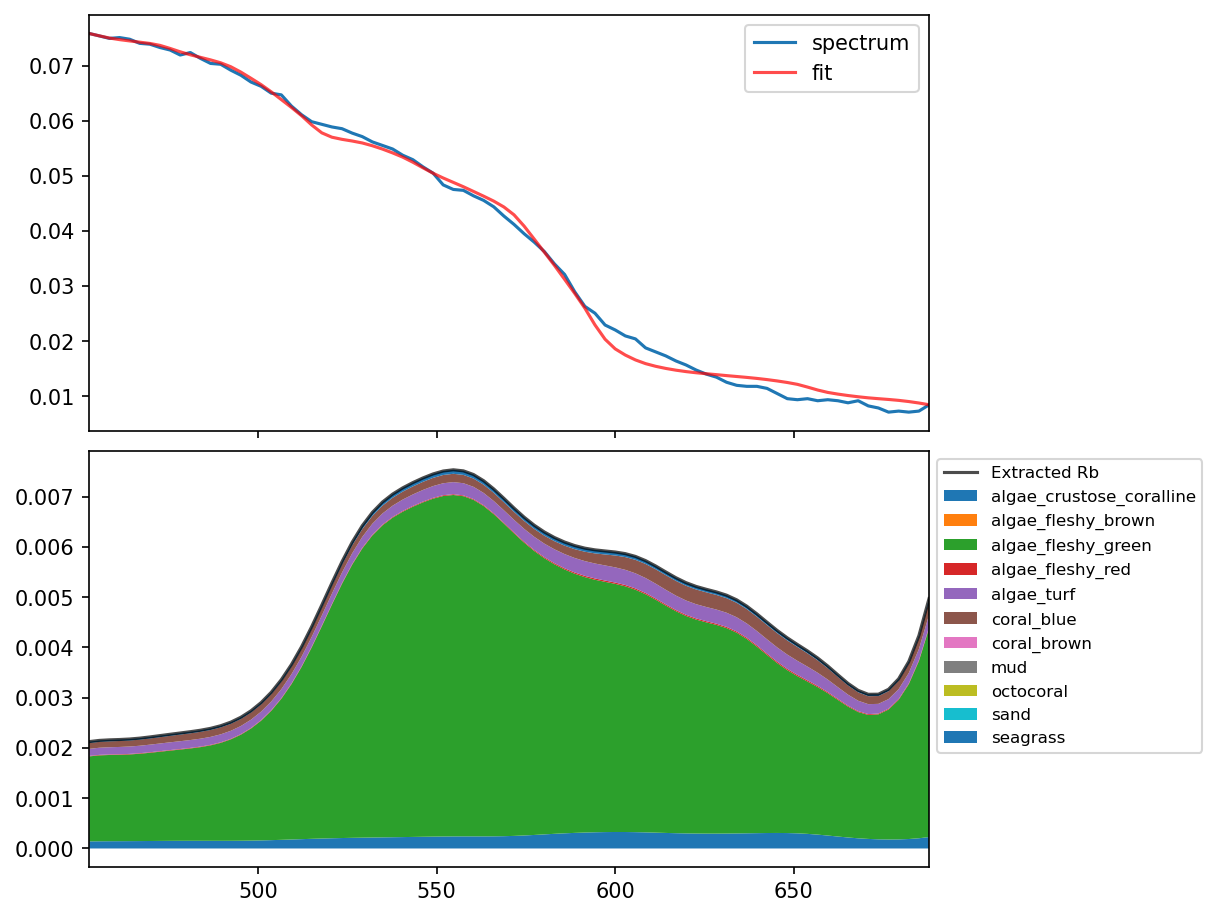

In [217]:
i = 999

fig, axs = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(8,6))

axs[0].plot(spectra.columns, spectra.loc[i], label='spectrum');
axs[0].plot(spectra.columns, sub_surface_reflectance_Rb(spectra.columns, *fits.loc[i].values[:-1], *AOD_args), color='red', alpha=0.7, label='fit')
axs[0].legend(bbox_to_anchor=(1,1))

axs[1].plot(spectra.columns, Rb_endmember(*fits.loc[i].values[-12:-1]), color='k', alpha=0.7, label='Extracted Rb')

axs[1].set_xlim(spectra.columns.min(), spectra.columns.max())

endmember_contribution = end_member_array * fits.loc[i].values[-12:-1].reshape(-1,1)
y = np.zeros(endmember_contribution.shape[1])
for label, endmember in zip(cats, endmember_contribution):
    ynew = y + endmember
    axs[1].fill_between(spectra.columns, y, ynew, label=label, lw=0)
    y = ynew
    
axs[1].legend(bbox_to_anchor=(1,1), fontsize=8)


In [233]:
threshold = 0.9

bad_fits = fits[fits.r2 < threshold]
good_fits = fits[fits.r2 >= threshold]

bad_fits.shape

(63, 15)

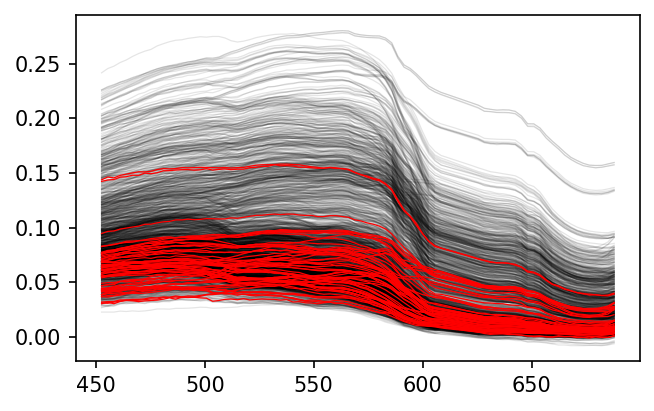

In [239]:
plt.plot(spectra.columns, spectra.loc[bad_fits.index].values.T, color='red', lw=0.6)
plt.plot(spectra.columns, spectra.loc[good_fits.index].values.T, color='k', alpha=0.1, lw=0.6, zorder=-2);

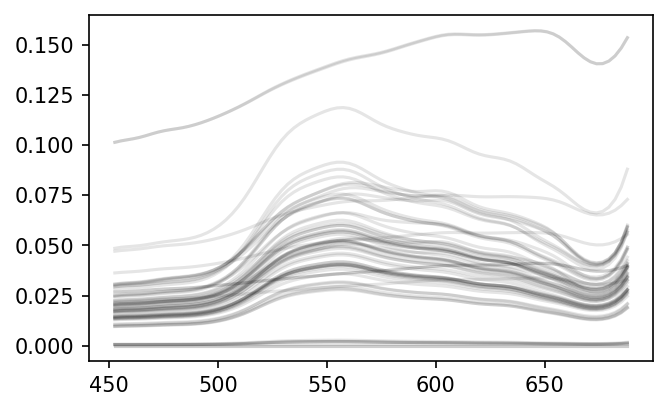

In [235]:
fig, ax = plt.subplots()

for i, row in bad_fits.iterrows():
    Rb = Rb_endmember(*fits.loc[i, cats].values)
    # Rb_fit = end_member_array.T.dot(row.values[:-1])
    ax.plot(spectra.columns, Rb, color='black', alpha=0.1)

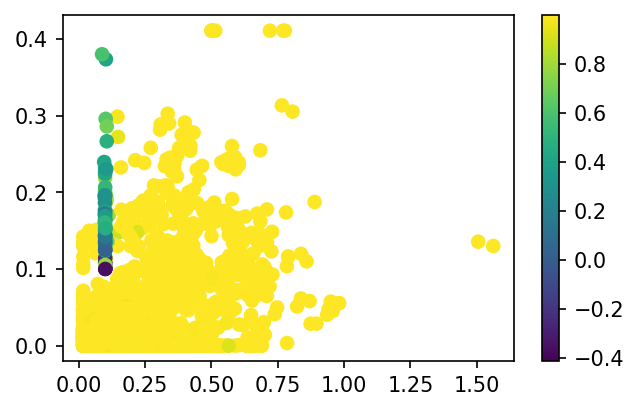

In [236]:
plt.scatter(fits.K, fits.bb, c=fits.r2)
plt.colorbar()

In [241]:
endmember_map = {
    'algae_crustose_coralline': ['algCCA'],
    'algae_fleshy_brown': ['algMacBrn'],
    'algae_fleshy_green': ['algMacGrn', 'algMacMix', 'algMacUnk', 'algCyano'],
    'algae_fleshy_red': ['algMacRed'],
    'algae_turf': ['algTurf'],
    'coral_blue': [],
    'coral_brown': ['crlCoral'],
    'mud': ['sedMud'],
    'octocoral': ['othOcto'],
    'sand': ['sedSand', 'crlBleach', 'sedLimest', 'sedRubble'],
    'seagrass': ['othSeagr'],
    # 'other': ['othClam', 'othInvert', 'othOther', 'othSponge', 'othUrchin']  # ignoring as max count is 3, and they don't fit categories well
}

validation_data_mapped = pd.DataFrame(index=validation_data.index, columns=endmember_map)

for k, v in endmember_map.items():
    validation_data_mapped.loc[:, k] = validation_data.loc[:, v].sum(axis=1) 

validation_data_mapped_norm = validation_data_mapped.divide(validation_data_mapped.sum(axis=1), axis=0)

fits_norm = fits.loc[:, cats]
fits_norm = fits_norm.divide(fits_norm.sum(axis=1), axis=0)

In [243]:
validation_data_mapped_norm['coral'] = validation_data_mapped_norm[['coral_blue', 'coral_brown']].sum(axis=1)
fits_norm['coral'] = fits_norm[['coral_blue', 'coral_brown']].sum(axis=1)

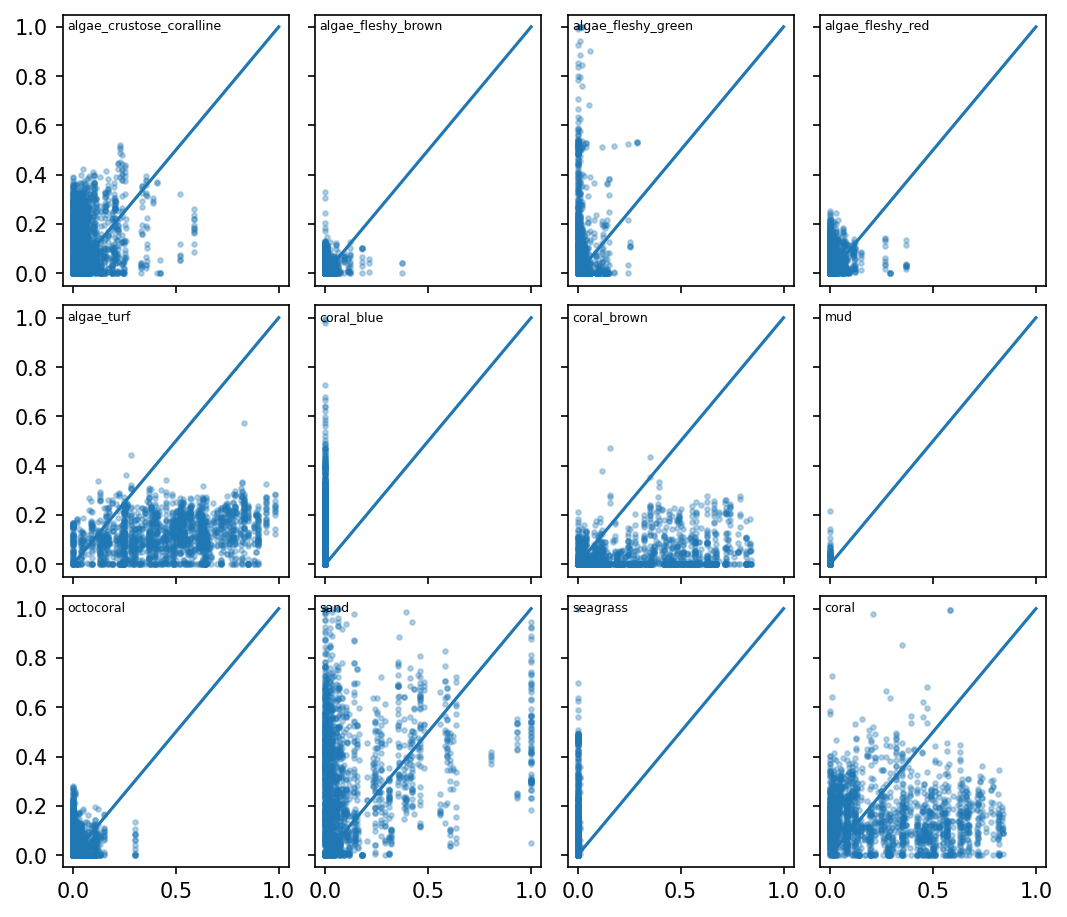

In [244]:
fig, axs = plt.subplots(3,4,figsize=[7, 6],sharex=True,sharey=True, constrained_layout=True)

for endmember, ax in zip(fits_norm.columns, axs.flat):
    ax.scatter(validation_data_mapped_norm[endmember], fits_norm[endmember], s=5, alpha=0.3)
    ax.text(0.02, 0.98, endmember, ha='left', va='top', transform=ax.transAxes, fontsize=6)
    
    ax.plot([0,1], [0,1])

In [324]:
import seaborn as sns
from sklearn.decomposition import PCA

In [503]:
new_categories = {
    'algae': ['algae_fleshy_brown', 'algae_fleshy_green', 'algae_fleshy_red', 'algae_turf', 'seagrass'],
    'CCA': ['algae_crustose_coralline'],
    'coral': ['coral_blue', 'coral_brown', 'octocoral'],
    'sand': ['sand', 'mud']
}

end_members = {}
pc1_end_members = {}

for cat in new_categories:
    ind = df.index.isin(new_categories[cat])
    end_members[cat] = df.loc[ind].mean(axis=0)
    
    pca = PCA(1).fit(df.loc[ind])
    pc1_end_members[cat] = pca.components_[0]
    
end_member_array = np.array([spectrum.values for spectrum in end_members.values()])
pc1_end_member_array = np.array([spectrum for spectrum in pc1_end_members.values()])

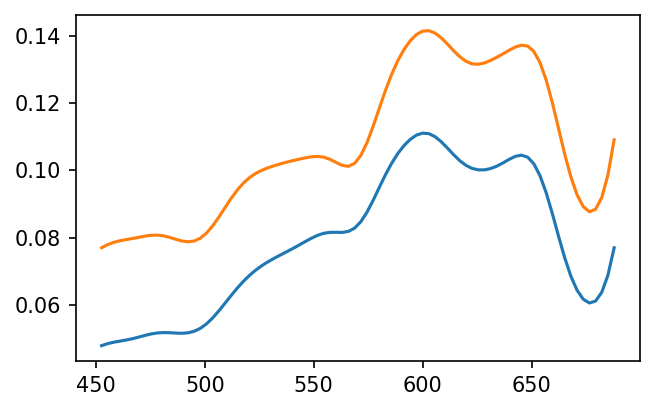

In [504]:
i = 1
plt.plot(spectra.columns, end_member_array[i])
plt.plot(spectra.columns, pc1_end_member_array[i])

In [279]:
end_member_array_norm = end_member_array - end_member_array.min(axis=1)[:, None]
end_member_array_norm /= end_member_array_norm.max(axis=1)[:, None]

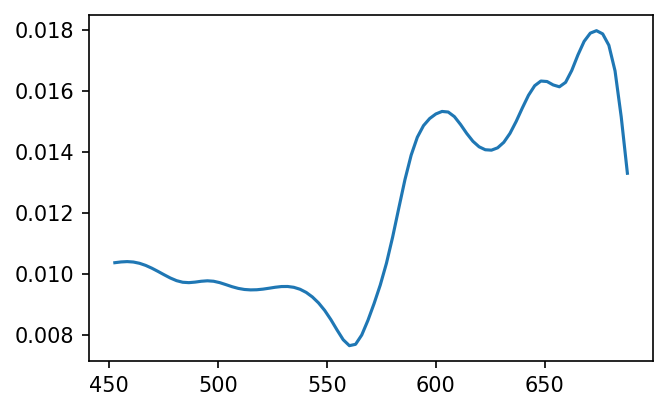

In [290]:
plt.plot(spectrum.index, end_member_array.std(axis=0))

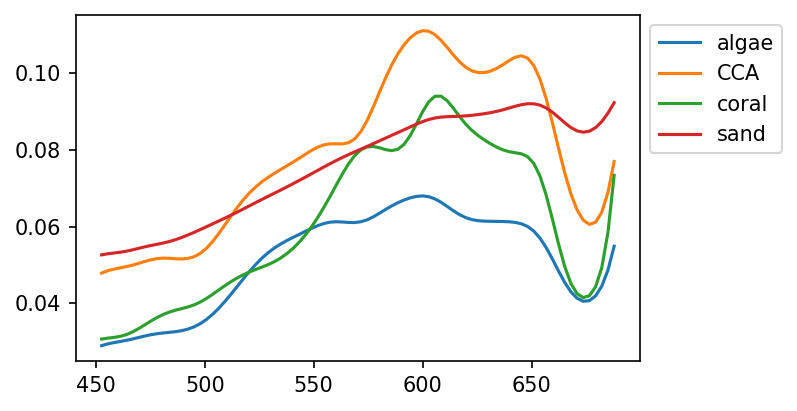

In [505]:
for cat, spectrum in end_members.items():
    y = spectrum
    # y -= y.min()
    # y /= y.max()
    plt.plot(spectra.columns, y, label=cat)
plt.legend(bbox_to_anchor=(1,1))

In [343]:
def objective_fn_w(x, obs, w, bb_m, bb_c, Kd_m, Kd_c):
    bb, K, H, *Rb = x
    Rb = Rb_endmember(*Rb)
    pred = sub_surface_reflectance(1, bb, K, H, Rb, bb_m, bb_c, Kd_m, Kd_c)
    
    ssq = np.sum(w * (obs - pred)**2)
    penalty = np.sum(np.array(Rb)**2)
    penalty_scale = ssq / max(penalty.max(), 1)  # doesn't this just remove the Rb penalty?
    return ssq + penalty_scale * penalty

def sub_surface_reflectance_Rb(wv, bb, K, H, Rb0, Rb1, Rb2, Rb3, bb_m, bb_c, Kd_m, Kd_c):
    Rb = Rb_endmember(Rb0, Rb1, Rb2, Rb3)
    return sub_surface_reflectance(wv, bb, K, H, Rb, bb_m, bb_c, Kd_m, Kd_c)

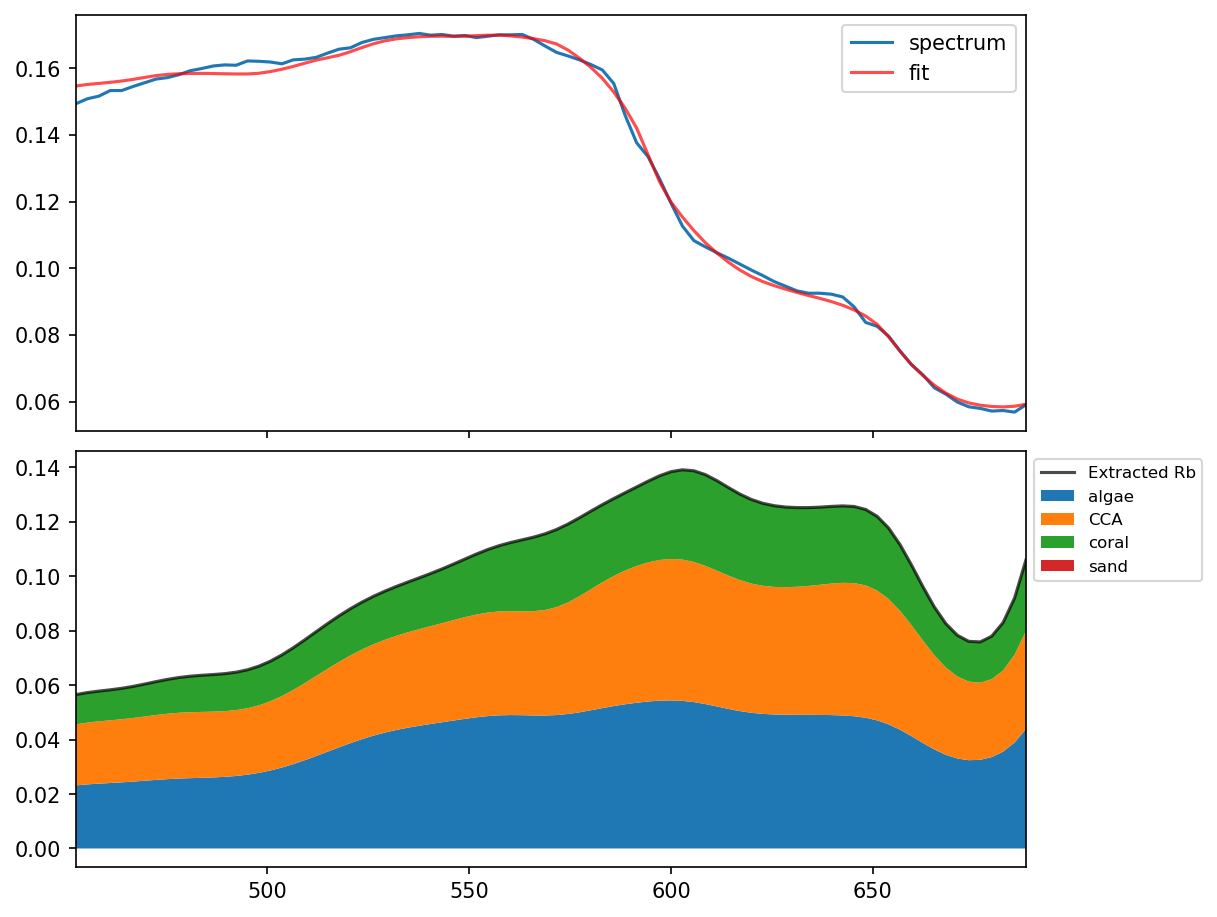

In [393]:
i = 2

wv = spectra.columns
# w = end_member_array.std(axis=0)
# w[0] = 1

# w = 0.5 * np.exp(0.01 * (wv - 450))
w = 1 + 4 * stats.norm.cdf(wv, loc=580, scale=20)

fit = minimize(objective_fn_w,
            x0=[0.1, 0.1, 0] + [0] * 4,
            args=(spectra.loc[i], w, *AOD_args),
            bounds=[(0, 0.41123), (0.01688, 3.17231), (0, 50)] + [(0, np.inf)] * 4)

fig, axs = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(8,6))

axs[0].plot(spectra.columns, spectra.loc[i], label='spectrum');
axs[0].plot(spectra.columns, sub_surface_reflectance_Rb(spectra.columns, *fit.x, *AOD_args), color='red', alpha=0.7, label='fit')
axs[0].legend(bbox_to_anchor=(1,1))

axs[1].plot(spectra.columns, Rb_endmember(*fit.x[-4:]), color='k', alpha=0.7, label='Extracted Rb')

axs[1].set_xlim(spectra.columns.min(), spectra.columns.max())

endmember_contribution = end_member_array * fit.x[-4:].reshape(-1,1)
y = np.zeros(endmember_contribution.shape[1])
for label, endmember in zip(end_members, endmember_contribution):
    ynew = y + endmember
    axs[1].fill_between(spectra.columns, y, ynew, label=label, lw=0)
    y = ynew
    
axs[1].legend(bbox_to_anchor=(1,1), fontsize=8)


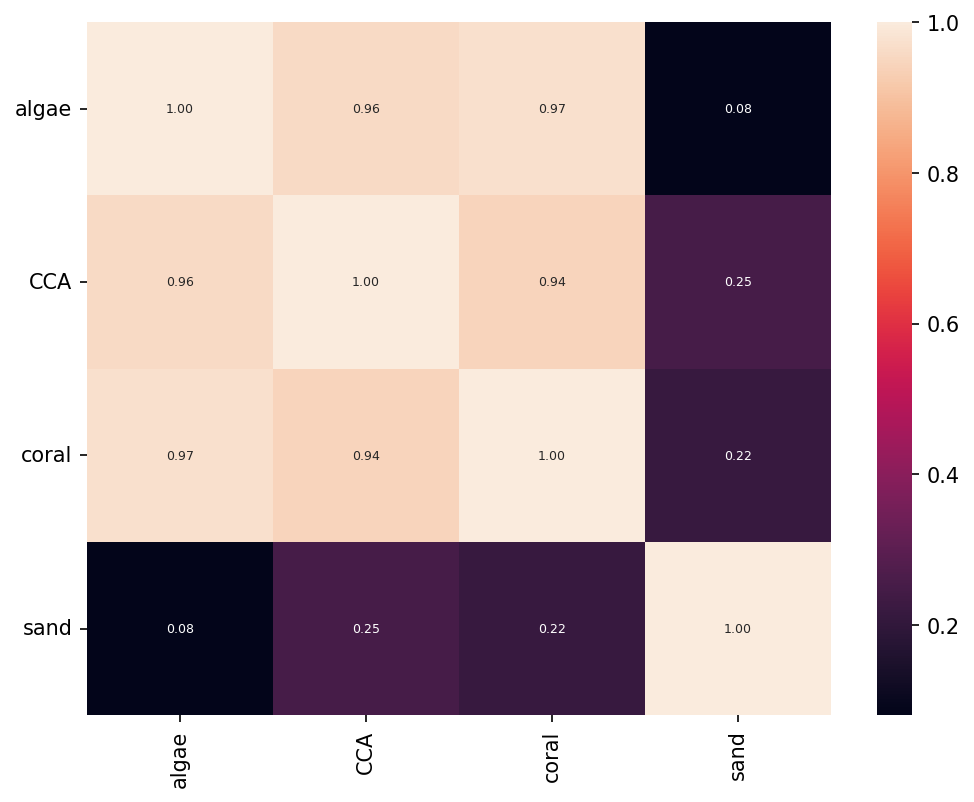

In [271]:
plt.figure(figsize=[8,6])
ax = sns.heatmap(np.corrcoef(end_member_array[:, 44:]), annot=True, fmt='.2f', annot_kws={'fontsize':6})
ax.set_xticklabels(end_members, rotation=90)
ax.set_yticklabels(end_members, rotation=0);

In [349]:
end_members.keys()

dict_keys(['algae', 'CCA', 'coral', 'sand'])

In [411]:
def objective_fn_w(x, obs, w, bb_m, bb_c, Kd_m, Kd_c):
    bb, K, H, *Rb = x
    Rb = Rb_endmember(*Rb)
    pred = sub_surface_reflectance(1, bb, K, H, Rb, bb_m, bb_c, Kd_m, Kd_c)
    
    ssq = np.sum(w * (obs - pred)**2)
    # penalty = np.sum(np.array(Rb)**2)
    # penalty_scale = ssq / max(penalty.max(), 1)  # doesn't this just remove the Rb penalty?
    return ssq #+ penalty_scale * penalty

def sub_surface_reflectance_Rb(wv, bb, K, H, Rb0, Rb1, Rb2, Rb3, bb_m, bb_c, Kd_m, Kd_c):
    Rb = Rb_endmember(Rb0, Rb1, Rb2, Rb3)
    return sub_surface_reflectance(wv, bb, K, H, Rb, bb_m, bb_c, Kd_m, Kd_c)

In [429]:
from matplotlib.colors import Normalize

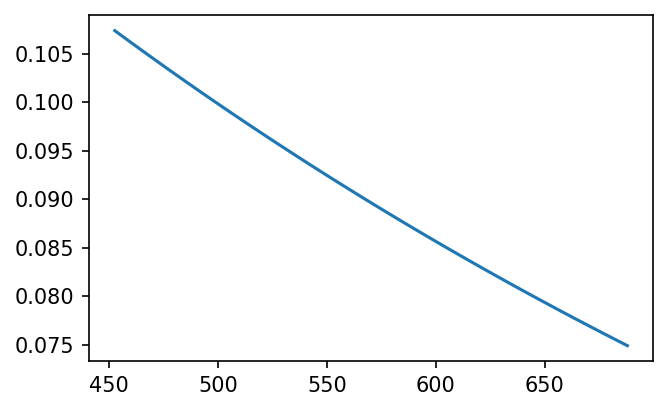

In [532]:
plt.plot(wv, AOD_args[0] * 1 + AOD_args[1], label='bb')

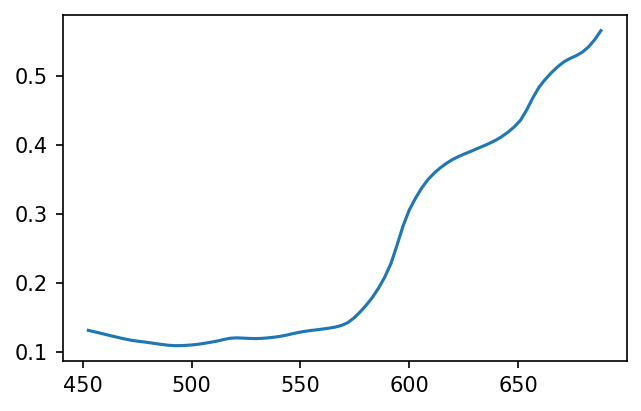

In [535]:
plt.plot(wv, AOD_args[2] * 1 + AOD_args[3], label='bb')


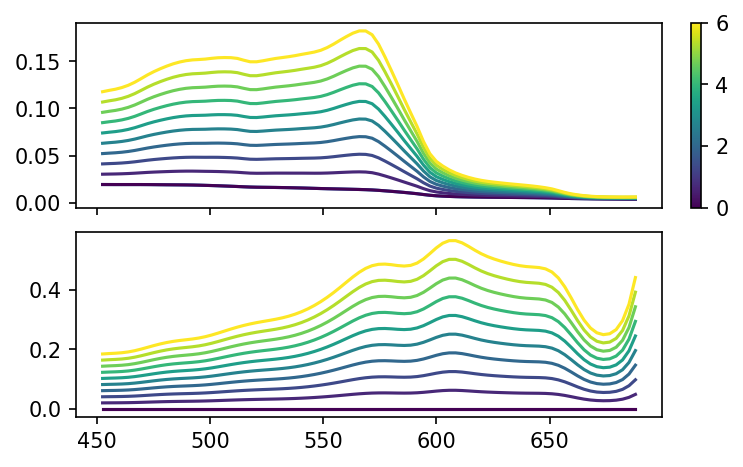

In [544]:
wv = spectra.columns
bb = 0.02
K = 0.2
H = 10

Rb0 = 0  # algae
Rb1 = 0  # CCA
Rb2 = 0.5  # coral
Rb3 = 0  # sand

def sub_surface_reflectance_Rb(wv, bb, K, H, Rb0, Rb1, Rb2, Rb3, bb_m, bb_c, Kd_m, Kd_c):
    Rb = Rb_endmember(Rb0, Rb1, Rb2, Rb3)
    return sub_surface_reflectance(wv, bb, K, H, Rb, bb_m, bb_c, Kd_m, Kd_c)

fig, axs = plt.subplots(2, 1, sharex=True, constrained_layout=True)

axs[0].plot(wv, sub_surface_reflectance_Rb(wv, bb, K, H, 0, 0, 0, 0, *AOD_args), label='Rb=0')

cmap = plt.cm.viridis
cnorm = Normalize(vmin=0, vmax=6)

for Rb2 in np.linspace(0, 6, 10):

    sim = sub_surface_reflectance_Rb(wv, bb, K, H, Rb0, Rb1, Rb2, Rb3, *AOD_args) 
    # sim += np.random.normal(0, 1e-4, len(wv))

    axs[0].plot(wv, sim, color=cmap(cnorm(Rb2)))

    axs[1].plot(wv, Rb_endmember(Rb0, Rb1, Rb2, Rb3), color=cmap(cnorm(Rb2)))

ma = plt.cm.ScalarMappable(cmap=cmap, norm=cnorm)
fig.colorbar(ma, ax=axs[0])

/tmp/ipykernel_690839/2184253235.py:38: RuntimeWarning: divide by zero encountered in divide
  fit.x[-4:] / [Rb0, Rb1, Rb2, Rb3]


array([0.18793331, 1.02764929, 0.84578402,        inf])

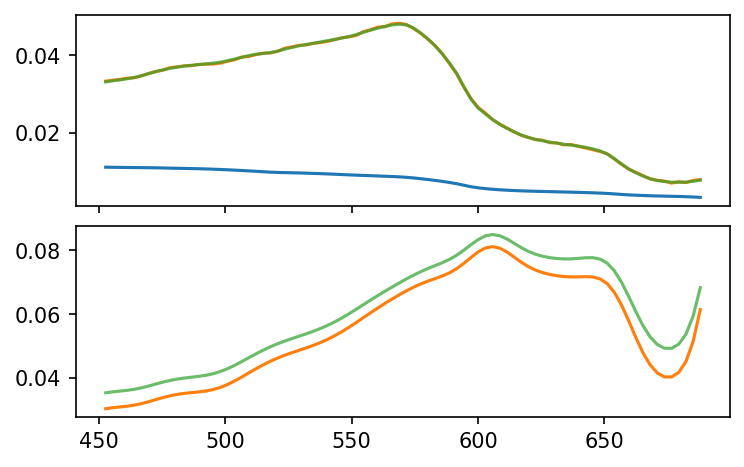

In [526]:
wv = spectra.columns
bb = 0.02
K = 0.2
H = 5

Rb0 = 0.1  # algae
Rb1 = 0.25  # CCA
Rb2 = 0.5  # coral
Rb3 = 0  # sand

def sub_surface_reflectance_Rb(wv, bb, K, H, Rb0, Rb1, Rb2, Rb3, bb_m, bb_c, Kd_m, Kd_c):
    Rb = Rb_endmember(Rb0, Rb1, Rb2, Rb3)
    return sub_surface_reflectance(wv, bb, K, H, Rb, bb_m, bb_c, Kd_m, Kd_c)

sim = sub_surface_reflectance_Rb(wv, bb, K, H, Rb0, Rb1, Rb2, Rb3, *AOD_args) 
sim += np.random.normal(0, 1e-4, len(wv))

fig, axs = plt.subplots(2, 1, sharex=True, constrained_layout=True)

axs[0].plot(wv, sub_surface_reflectance_Rb(wv, bb, K, H, 0, 0, 0, 0, *AOD_args), label='Rb=0')

axs[0].plot(wv, sim)

axs[1].plot(wv, Rb_endmember(Rb0, Rb1, Rb2, Rb3), color='C1')

w = 1

fit = minimize(objective_fn_w,
            x0=[0.1, 0.1, 0] + [0] * 4,
            args=(sim, w, *AOD_args),
            bounds=[(0, 0.41123), (0.01688, 3.17231), (0, 50)] + [(0, np.inf)] * 4, tol=1e-9)

pred = sub_surface_reflectance_Rb(wv, *fit.x, *AOD_args)
axs[0].plot(wv, pred, color='C2', alpha=0.7, label='fit')

axs[1].plot(wv, Rb_endmember(*fit.x[-4:]), color='C2', alpha=0.7, label='Extracted Rb')

fit.x[-4:] / [Rb0, Rb1, Rb2, Rb3]

/tmp/ipykernel_690839/1252393770.py:21: RuntimeWarning: divide by zero encountered in divide
  fit.x[-4:] / [Rb0, Rb1, Rb2, Rb3]


array([1.79941484, 0.63146959, 1.01925223,        inf])

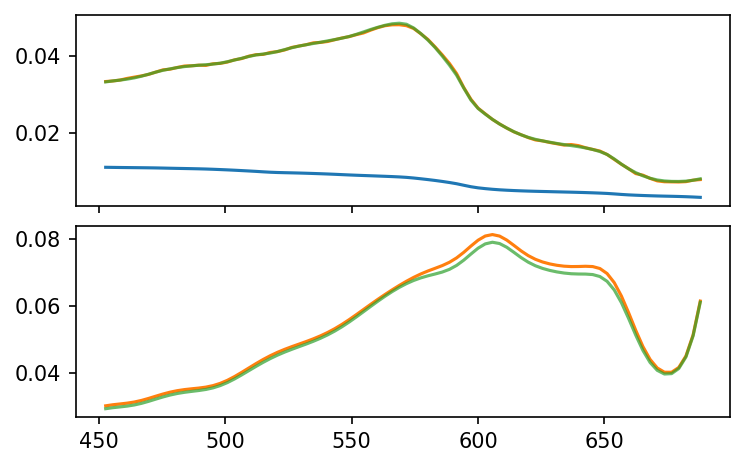

In [422]:
fit.x[-4:]

array([0.00215049, 0.23144008, 0.39799717, 0.28865027])

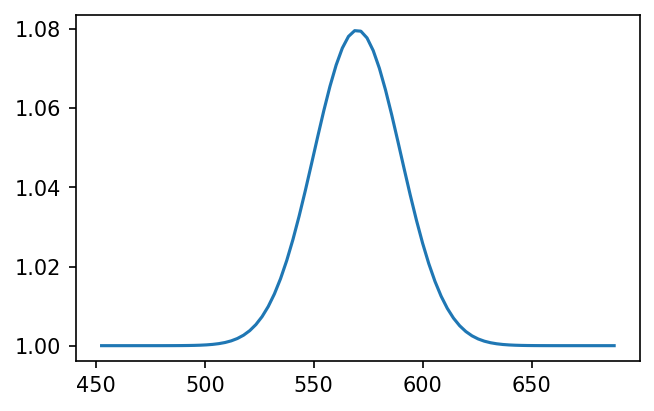

In [528]:
plt.plot(wv,1 + 4 * stats.norm.pdf(wv, loc=570, scale=20))


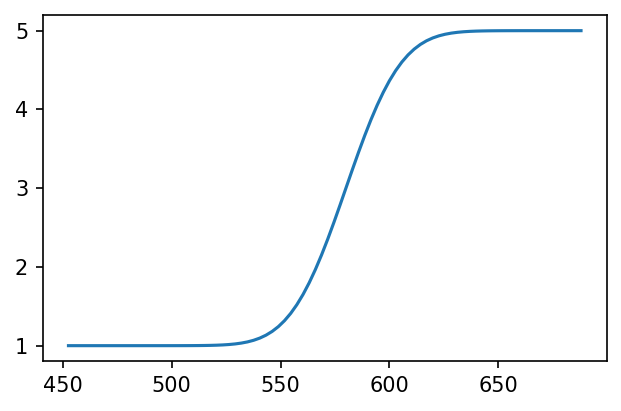

In [423]:
plt.plot(wv,1 + 4 * stats.norm.cdf(wv, loc=580, scale=20))